In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)


def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)


def FC_layer(X, W, b):
    return tf.matmul(X, W) + b


def create_network(h_dim, latent_dim):
    # ENCODER
    W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
    b_enc = bias_variable([h_dim], 'b_enc')
    h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

    W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
    b_mu = bias_variable([latent_dim], 'b_mu')
    mu = FC_layer(h_enc, W_mu, b_mu)

    W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
    b_logstd = bias_variable([latent_dim], 'b_logstd')
    logstd = FC_layer(h_enc, W_logstd, b_logstd)

    noise = tf.random_normal([1, latent_dim])
    z = mu + tf.mul(noise, tf.exp(.5*logstd))

    # DECODER
    W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
    b_dec = bias_variable([h_dim], 'b_dec')
    h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))

    W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
    b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
    reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

    # LOSS
    log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
    KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)

    variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
    optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

    return optimizer, reconstruction, log_likelihood, KL_term, variational_lower_bound, z

In [15]:
def train(num_iterations=1000000):
    saver = tf.train.Saver()
    global optimizer, reconstruction, log_likelihood, KL_term, variational_lower_bound
    recording_interval = 1000
    variational_lower_bound_array = []
    log_likelihood_array = []
    KL_term_array = []
    iteration_array = [i*recording_interval for i in range(int(num_iterations/recording_interval))]
    for i in range(num_iterations):
        x_batch = np.round(mnist.train.next_batch(200)[0])
        sess.run(optimizer, feed_dict={X: x_batch})
        if (i%recording_interval == 0):
            vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
            print("Iteration: {}, Loss: {}".format(i, vlb_eval))
            variational_lower_bound_array.append(vlb_eval)
            log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
            KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

    saver.save(sess, os.path.join(os.getcwd(), "tmp/model.ckpt"))


def test_reconstruction():
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join(os.getcwd(), "tmp/model.ckpt"))

    num_pairs = 10
    image_indices = np.random.randint(0, 200, num_pairs)
    for pair in range(num_pairs):
        x = np.reshape(mnist.test.images[image_indices[pair]], (1,n_pixels))
        plt.figure()
        x_image = np.reshape(x, (28,28))
        plt.subplot(121)
        plt.imshow(x_image)

        x_reconstruction = reconstruction.eval(feed_dict={X: x})
        x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
        plt.subplot(122)
        plt.imshow(x_reconstruction_image)


def sample(latent_dim, n_samples):
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join(os.getcwd(), "tmp/model.ckpt"))

    samples = []
    for i in range(n_samples):
        z = np.random.normal(size=latent_dim)
        samples.append(reconstruction.eval(feed_dict={z: z}))
    return samples

In [5]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
n_pixels = 28*28
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
latent_dim = 20
h_dim = 500
optimizer, reconstruction, log_likelihood, KL_term, variational_lower_bound, z = create_network(h_dim,latent_dim)

In [7]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [11]:
train(10000)

Iteration: 0, Loss: -555.8272094726562
Iteration: 1000, Loss: -527.0939331054688
Iteration: 2000, Loss: -524.13232421875
Iteration: 3000, Loss: -489.6903076171875
Iteration: 4000, Loss: -474.3379821777344
Iteration: 5000, Loss: -433.1575927734375
Iteration: 6000, Loss: -433.3534240722656
Iteration: 7000, Loss: -408.18414306640625
Iteration: 8000, Loss: -390.45733642578125
Iteration: 9000, Loss: -376.4394226074219


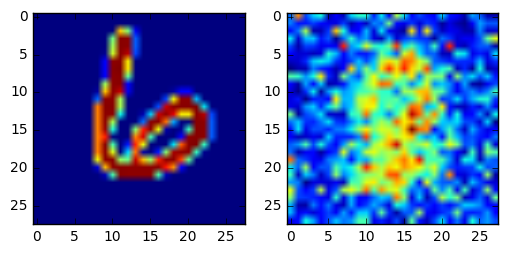

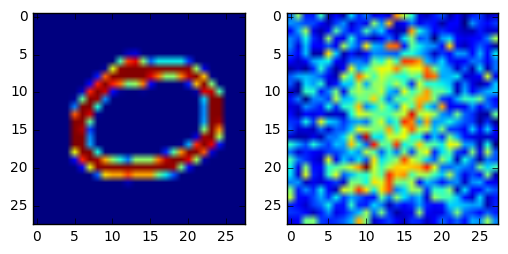

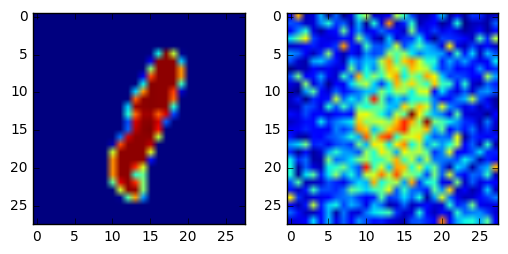

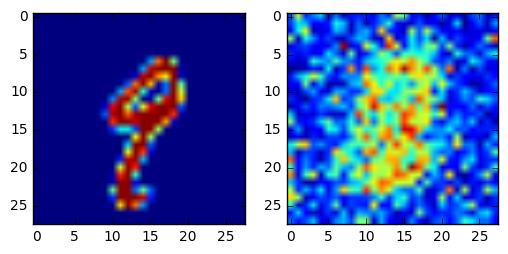

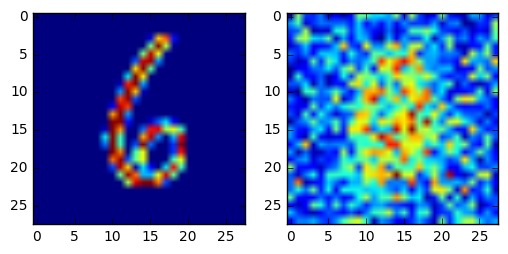

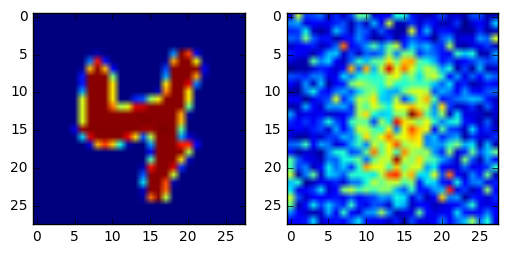

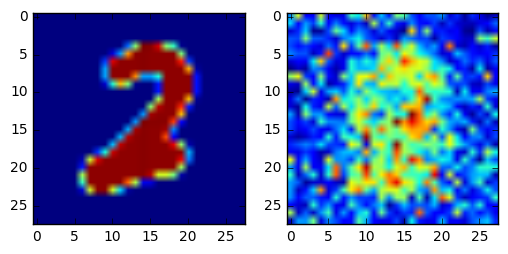

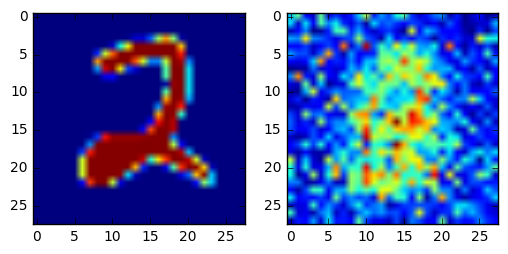

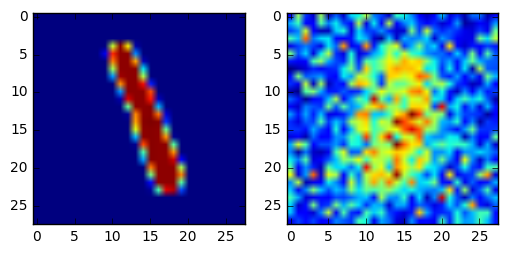

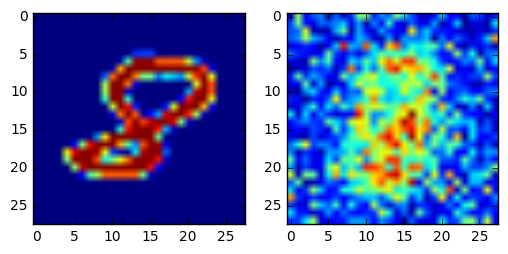

In [14]:
test_reconstruction()

In [24]:
z = np.random.normal(size=[1, latent_dim])

In [29]:
sess.run(reconstruction, feed_dict={z: z})

TypeError: unhashable type: 'numpy.ndarray'